# 미니 프로젝트 : 가위바위보 분류기

가위바위보! 어렸을 때 많이 해보던 게임을 컴퓨터로 분류해보자!  

## 1. 데이터 준비

구글이 머신러닝을 쉽게 할 수 있도록 만든 [Teachable Machine](https://teachablemachine.withgoogle.com/) 사이트를 통해 datasets을 만들 수 있다.  

데이터 생성시 주의 사항
- 다양성
- 충분한 양의 데이터

datasets의 영향을 많이 받는 많큼 충분한 양의 데이터가 필요했고 여기서는 가위, 바위, 보 각각 500장으로 학습을 시켰다.  
**다양성**을위해 손을 여러 각도로 회전하며 다양한 관점의 가위, 바위 보 이미지를 얻어 일반화 성능을 높였다.  

In [2]:
from PIL import Image
import os, glob

### 1-1) 데이터 불러오기 + Resize 하기

전에 다뤄봤던 MNIST datasets은 28x28 이미지였지만 사이트를 통해 만든 이미지가 224x224를 갖도록 만들어준다.

In [3]:
import os

def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 224x224 사이즈로 바꾸어 저장합니다.
	target_size=(224,224)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

500  images to be resized.
500  images resized.
500  images to be resized.
500  images resized.
500  images to be resized.
500  images resized.
가위 이미지 resize 완료!


In [14]:
import numpy as np

def load_data(img_path, size, number_of_data=1500):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=size
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
image_test_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_train, y_train)=load_data(image_dir_path, 224)
(x_test, y_test) = load_data(image_test_path, 224)
x_train_norm, x_test_norm = x_train/255.0, x_test/255.0   # 입력은 0~1 사이의 값으로 정규화


print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 1500 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (1500, 224, 224, 3)
y_train shape: (1500,)
x_test shape: (1500, 224, 224, 3)
y_test shape: (1500,)


라벨:  0


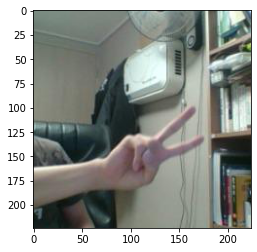

In [15]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
# plt.imshow(x_test[0])
print('라벨: ', y_train[0])

In [8]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [9]:
# x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0
# print('최소값:', np.min(x_train_norm), '최대값:', np.max(x_train_norm))

x_train_reshaped = x_train_norm.reshape(-1, 224, 224, 3)    # 데이터 개수에 -1을 쓰면 reshape시 자동계산
x_test_reshaped = x_test_norm.reshape(-1, 224, 224, 3)      # 채널수 1은 흑백 이미지, 컬러이미지는 3

print("After Reshape - x_train_reshaped shape:{}".format(x_train_reshaped.shape))

After Reshape - x_train_reshaped shape:(1500, 224, 224, 3)


## 2. 딥러닝 네트워크 설계하기

가위, 바위, 보를 학습하기 위한 딥러닝 네트워크를 설계한다.  

- 라이브러리: Keras
- 모델: tf.Keras의 Sequential Model



아래는 모델을 만든 과정이다.  
1) 2번의 layers(conv + pooling)와 1개의 Dense layer + softmax를 쌓아보니 accuracy가 0.3으로 매우 낮았다.  
2) 중간에 layers(conv + pooling)를 추가를 해보았으나 overfitting되는 문제가 발생했다.  
3) Dropout을 사용해 overfitting을 해결해보려고 했으나 실패  
4) 1번 구조에서 Dataset만 늘려보기로 결정 (기존 300장 -> 1500장)  


## 3. 모델 학습시키기


In [16]:
import random
seed = int(42)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

n_channel_1 = 16
n_channel_2 = 32
n_channel_3 = 128
n_channel_4 = 256

n_dense = 32
n_train_epoch = 10

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(224,224,3)))
# model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
# model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling2D((2,2)))
# model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.MaxPooling2D((2,2)))
# model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
# model.add(keras.layers.MaxPooling2D((2,2)))
# model.add(keras.layers.Conv2D(n_channel_4, (3,3), activation='relu'))
# model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
# model.add(keras.layers.Dense(n_dense, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2986016   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

## 4. 모델 성능 평가

test datasets은 다른 사람의 데이터셋을 가져왔다.  

In [17]:
# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {}".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

47/47 - 1s - loss: 7.3865 - accuracy: 0.8667
test_loss: 7.386472702026367
test_accuracy: 0.8666666746139526


### 모델의 최종 성능 86.67%

In [18]:
predicted_result = model.predict(x_train_reshaped)   # model이 추론한 확률값
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0 # 1번째 x_test를 살펴보자.
print('model.predict() 결과:', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과:', predicted_labels[idx])
print('실제 데이터의 라벨:', y_test[idx])

model.predict() 결과: [1.0000000e+00 1.9801783e-20 5.0607277e-36]
model이 추론한 가장 가능성이 높은 결과: 0
실제 데이터의 라벨: 0


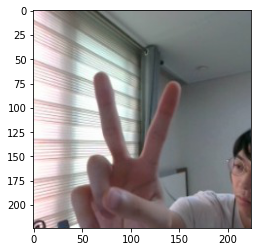

In [19]:
plt.imshow(x_test[idx], cmap=plt.cm.binary)
plt.show()